# Final assignment (ResNet101 model)

Subject: Computer vision subject

Student: Huynh Duc Minh - 20212456M

Topic: Apply Mask R-CNN for digestive system injure detection

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/huynhmink/miniconda3/envs/compvision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/huynhmink/miniconda3/envs/compvision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/huynhmink/miniconda3/envs/compvision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/huynhmink/minico

# Config

In [2]:
class MinhConfig(Config):
    """Configuration for training on the digestive system dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Minh"

    BACKBONE = "resnet101"

    # Train on 1 GPU and 1 images per GPU. Use 1 image as GPU only have 2Gb of VRAM. 
    # Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 3 type of injure

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1782
    # Total number of image in the training dataset is 1782

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 600
    # Total number of image in the validation dataset is 591
    
config = MinhConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset

Custom script to load the dataset

The mask data is in PNG format

In [8]:
dataset_dir = "../dataset/"
class MinhDataset(utils.Dataset):
    def load_minh(self,dataset_dir,subset):

        #add class
        self.add_class("minh",1,"1_ung_thu_thuc_quan")
        self.add_class("minh",2,"2_viem_thuc_quan")
        self.add_class("minh",3,"3_viem_da_day_hp_am")
        self.add_class("minh",4,"4_viem_da_day_hp_duong")
        self.add_class("minh",5,"5_loet_hoanh_ta_trang")
        self.add_class("minh",6,"6_ung_thu_da_day")

        #train or val dataset
        for i_class in os.listdir(dataset_dir):
            for i_sub_class in os.listdir(os.path.join(dataset_dir,i_class)):
                if i_sub_class == subset:
                    for i_image_name in os.listdir(os.path.join(dataset_dir,i_class,i_sub_class,"images")):
                        i_image_path = os.path.join(dataset_dir,i_class,i_sub_class,"images",i_image_name)
                        i_image_mask_path = os.path.join(dataset_dir,i_class,i_sub_class,"mask_images",os.path.splitext(i_image_name)[0]+".png")
                        image = skimage.io.imread(i_image_path)
                        height,width = image.shape[:2]
                        self.add_image("minh",image_id=i_image_path,path=i_image_path,mask_path=i_image_mask_path,width=width,height=height,custom_class=i_class)
    #def load_image(self,image_id):
    #    image_path = self.image_info[image_id]
    #    image = skimage.io.imread(image_path)
    #    return image
    def load_mask(self,image_id):
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], 1], dtype=np.uint8)
        mask_png = skimage.io.imread(info["mask_path"])
        mask_png.shape = mask_png.shape + (1,)
        mask_class = [int(info["custom_class"][0])]
        return mask_png, np.array(mask_class, dtype=np.int32)
        #return mask_png, mask_class

In [9]:
dataset_train = MinhDataset()
dataset_train.load_minh(dataset_dir,"train")
dataset_train.prepare()

dataset_val = MinhDataset()
dataset_val.load_minh(dataset_dir,"val")
dataset_val.prepare()

[4]


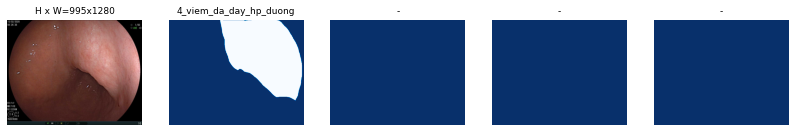

[3]


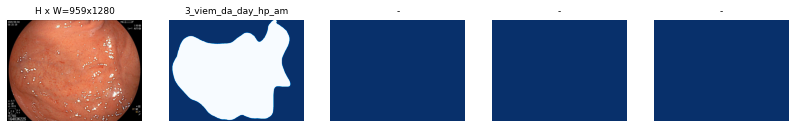

[2]


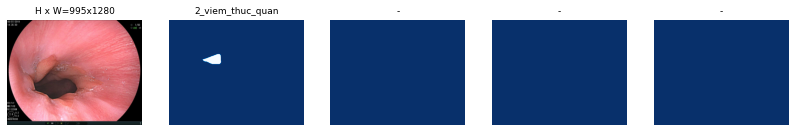

In [6]:
image_ids = np.random.choice(dataset_train.image_ids,3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask,class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [4]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# Which weights to start with?
init_with = "trained_resnet101"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

elif init_with == "trained_resnet101":
    model.load_weights(os.path.join(ROOT_DIR, "logs", "minh20220529T2040" , "mask_rcnn_minh_0039.h5"),by_name=True)

Re-starting from epoch 39


In [9]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            layers='all')


Starting at epoch 10. LR=0.001

Checkpoint Path: /home/huynhmink/Desktop/Mask_RCNN/logs/minh20220529T2040/mask_rcnn_minh_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

/home/huynhmink/miniconda3/envs/compvision/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/huynhmink/miniconda3/envs/compvision/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 11/40
1781/1782 [============================>.] - ETA: 0s - loss: 0.4167 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.2253

/home/huynhmink/miniconda3/envs/compvision/lib/python3.6/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1782/1782 [==============================] - 1289s - loss: 0.4167 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.2253 - val_loss: 2.2907 - val_rpn_class_loss: 0.0127 - val_rpn_bbox_loss: 1.5420 - val_mrcnn_class_loss: 0.1783 - val_mrcnn_bbox_loss: 0.2583 - val_mrcnn_mask_loss: 0.2994
Epoch 12/40
1782/1782 [==============================] - 1173s - loss: 0.3791 - rpn_class_loss: 9.4283e-04 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.2139 - val_loss: 2.7379 - val_rpn_class_loss: 0.0157 - val_rpn_bbox_loss: 1.6941 - val_mrcnn_class_loss: 0.2961 - val_mrcnn_bbox_loss: 0.2971 - val_mrcnn_mask_loss: 0.4348
Epoch 13/40
1782/1782 [==============================] - 1164s - loss: 0.3574 - rpn_class_loss: 9.0927e-04 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.2055 - val_loss: 2.8402 - val_rpn_class_loss: 0.0189 - va

In [6]:
class InferenceConfig(MinhConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "logs", "minh20220529T2040" , "mask_rcnn_minh_0039.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /home/huynhmink/Desktop/Mask_RCNN/logs/minh20220529T2040/mask_rcnn_minh_0039.h5
Re-starting from epoch 39


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max: 1280.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   30.00000  max:  251.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:  255.00000  uint8


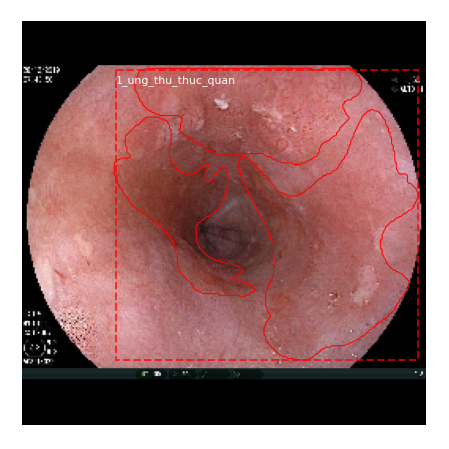

In [10]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


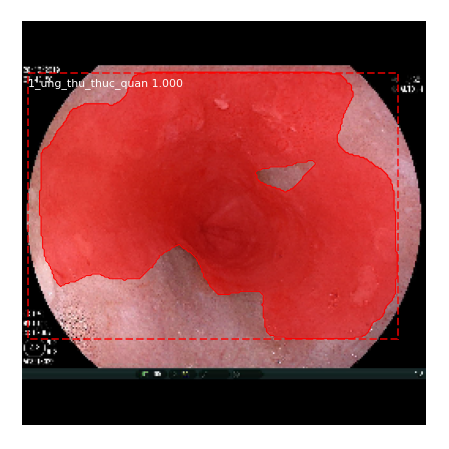

In [11]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [16]:
# Compute VOC-Style mAP @ IoU=0.5
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.425
